## Identification of people smoking 

In this notebook we will train a model to identify pictures containing people smoking, using [fast.ai](https://fast.ai) 

For the training we will be using this [dataset](https://www.kaggle.com/raj713335/cigrarette-data)

In [1]:
from fastai.vision.all import *

Import the dataset and verify it contains the folders for:
* Training
* Validation
* Testing

In [2]:
folder = Path('../input/cigrarette-data/smokingVSnotsmoking/dataset')
folder.ls()

(#3) [Path('../input/cigrarette-data/smokingVSnotsmoking/dataset/testing_data'),Path('../input/cigrarette-data/smokingVSnotsmoking/dataset/validation_data'),Path('../input/cigrarette-data/smokingVSnotsmoking/dataset/training_data')]

Just for sanitization, let's check for corrupted files and delete them, if they exist

In [3]:
# Check for corrupted files

fns = get_image_files(folder)
corrupted = verify_images(fns)
print(len(corrupted), " corrupted files found")

# Delete corrupted files
if len(corrupted) > 0:
    corrupted.map(Path.unlink)

0  corrupted files found


In the dataset, the folder structure splits the images between `smoking` and `notsmoking` (images containing people smoking or not smoking).

We will define a function that creates a label `Yes` or `No` depending on the folder, and that's the labeling system we will use.

Also we define our `DataBlock` to process images in the model, in the two categories defined by the labels. We split the data according to the folder it is contained (for training and validation), and resize the images to 224px.

Then we create our Data Loader, and print some sample images from the two sets

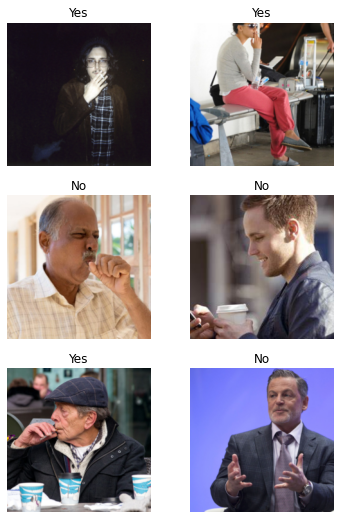

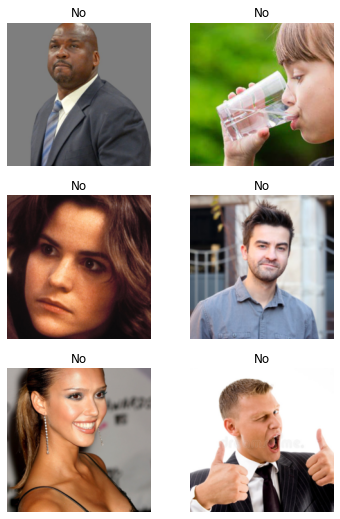

In [4]:
def smoking_(x):
  return 'Yes' if parent_label(x)=='smoking' else 'No'
  
image_set = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,         
    splitter=GrandparentSplitter(train_name='training_data', valid_name='validation_data'),
    get_y=smoking_,                                        
    item_tfms=Resize(224))

dls = image_set.dataloaders(folder)                         

dls.train.show_batch(max_n=6, nrows=3)  
dls.valid.show_batch(max_n=6, nrows=3)        

### Optional

We can try some data augmentation to compare the model performance with and without it

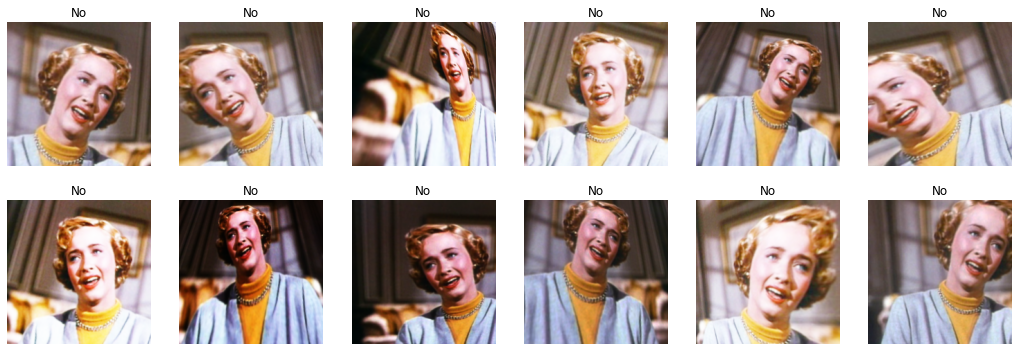

In [5]:
image_set = image_set.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(mult=2, do_flip=True, p_affine=0.75, max_rotate=10, min_scale=0.5)
)

dls = image_set.dataloaders(folder)
dls.show_batch(max_n=12, nrows=2, unique=True)

With the Data Loaders ready, let's set up a Convolutional Neural Network using a pretrained ResNet34 model, and run it for 8 iterations.

Interesting question: why use `fine_tune` here instead of `fit`?

In [6]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, pretrained=True)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.933846,0.672044,0.802500,00:47


epoch,train_loss,valid_loss,accuracy,time
0,0.663217,0.602643,0.812500,00:49
1,0.564328,0.295557,0.917500,00:49
2,0.498008,0.332575,0.912500,00:48
3,0.449398,0.505405,0.855000,00:48
4,0.389791,0.321532,0.902500,00:49
5,0.322901,0.241754,0.930000,00:48
6,0.272470,0.271787,0.920000,00:48
7,0.245299,0.280914,0.915000,00:48


Let's generate our confusion matrix and print our top 10 losses 

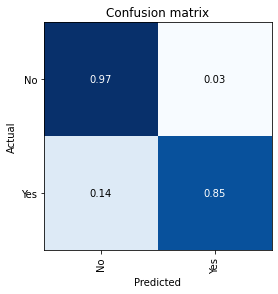

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize='all')

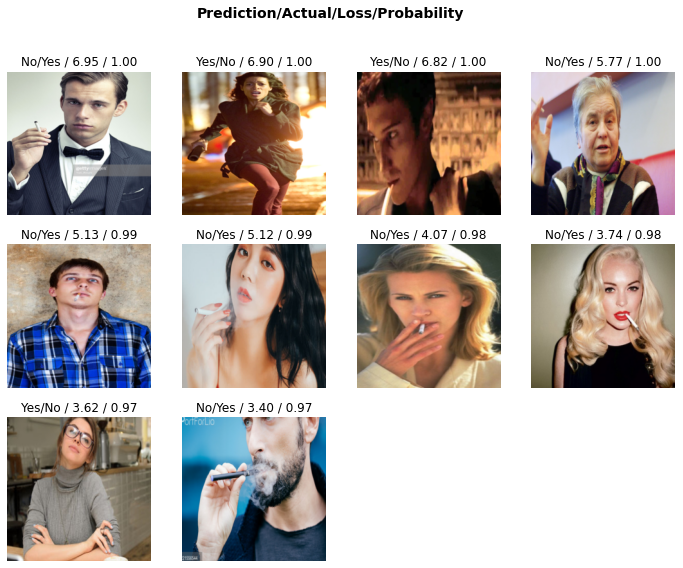

In [8]:
interp.plot_top_losses(10, nrows=3)


***Pending:*** Now let's check against the `testing_data`